In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
style.use('fivethirtyeight')
sns.set(style='darkgrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# specifically for models
from keras.layers import Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout
from keras.applications.vgg19 import VGG19
from keras.applications import ResNet50V2

#callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  

# Task 1

## Data Ingestion

- We loop through all the images in all the directories, load each image using OpenCV, resize it into a fixed size (256) and append the image data and its corresponding label to the global lists IMAGE and LABEL, respectively. 
- Then, we return these lists to create the training and validation dataset for the models.

In [2]:
IMAGE=[]
LABEL=[]
IMG_SIZE=256

# Define function to map image with label
def assign_label(img,flower_category):
    return flower_category

# Define function to create train data including resizing image
def make_train_data(flower_category,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_category)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        IMAGE.append(np.array(img))
        LABEL.append(str(label))

FLOWER_DIR = []
flower_categories = ["Babi", "Calimerio", "Chrysanthemum", "Hydrangeas", "Lisianthus", "Pingpong", "Rosy", "Tana"]

for category in flower_categories:
    flower_dir = f"Flowers_Cleaned/Flowers/{category}"
    FLOWER_DIR.append(flower_dir)
    make_train_data(category, flower_dir)
print('Total Image: ' + str(len(IMAGE)))

100%|███████████████████████████████████████████████████████████████████████████████| 488/488 [00:00<00:00, 952.48it/s]

Total Image: 4193


- We encode the labels using LabelEncoder, convert them to one-hot encoded vectors and store them in Y. 
- Then, we convert the image data to numpy array, scale the data to values between 0-1 and store them in X.

In [3]:
num_categories = 8

label_encoder=LabelEncoder()
Y=label_encoder.fit_transform(LABEL)
Y=to_categorical(Y,num_categories)
X=np.array(IMAGE)
X=X/255

## Data Splitting

- We split the data into two set:
    + Training dataset: 80% of the total dataset.
    + Validation dataset: 20% of the total dataset.

In [4]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

# Confirm the shapes of the data splits
print("Train set shapes:", x_train.shape, y_train.shape)
print("Test set shapes:", x_test.shape, y_test.shape)

Train set shapes: (3354, 256, 256, 3) (3354, 8)
Test set shapes: (839, 256, 256, 3) (839, 8)


- We ensure that the same train-test split is generated every time we run the code, which is useful for reproducibility.
- This allows you to compare the results of different models or hyperparameters on the same train-test split.

In [5]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Data Augmentation

- By randomly applying changes to the original images, these configurations enable the development of augmented images, which are slightly changed copies of the original images. 
- This can assist to increase the size and variability of the training set, which can improve the model's performance.

In [6]:
data_aug = ImageDataGenerator(
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                zoom_range = 0.1, # Randomly zoom image 
                width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)  # randomly flip images

## Models

### CNN Model

By using their unique design to extract useful patterns and characteristics from visual input, Convolutional Neural Networks (CNNs) have completely changed the area of computer vision. CNNs are excellent at tasks like picture categorization, object identification, and image recognition because they are inspired by the human visual system. CNNs are very good at processing and comprehending complicated visual data because they include convolutional layers and parameter sharing, which effectively capture local patterns and spatial correlations. CNNs have established themselves as the mainstay of contemporary computer vision applications thanks to their exceptional performance and ubiquitous use, pushing the limits of what is practical in the field of visual perception.

**CNN: Advantages and Disadvantages**

> **Advantages**
1. `Effective Feature Extraction`: CNNs excel in extracting hierarchical properties from input data, especially visual tasks. They capture crucial patterns and representations for successful image identification and categorization.

2. `Spatial Invariance`: CNNs detect objects and patterns in photos regardless of orientation. CNNs may rotate and scale.

3. `Parameter Sharing`: CNNs use learned weights (filters) to share parameters. Reduced parameter count improves CNN computational speed and allows huge dataset processing.

4. `Hierarchical Representation Learning`: Layered CNNs describe complex and abstract traits hierarchically. Hierarchical learning helps them analyze complicated visual data.

> **Disadvantages**
1. `Large Memory and Computational Requirements`: CNNs are computationally costly, particularly deeper designs with several layers. CNN training and deployment may need GPUs.

2. `Data Dependency`: CNNs need plenty of labeled training data to generalize and be accurate. In specialist fields, acquiring and compiling such datasets is time-consuming and costly.

3. `Lack of Interoperability`: CNNs are accurate but hard to understand. The network's intricate connections and transformations make predictions hard to comprehend.

4. `Vulnerability to Adversarial Attacks`: CNNs may be fooled by purposely generated disturbances. Security-sensitive apps face this issue.


#### Build and Train Model

- We design this model with 5 convolution layers with max pooling layers in between, followed by a flatten layer, a dense layer and an output layer.
- First, Conv2D layer has 32 filters, a kernel size of (5,5), and "same" padding. The activation function is ReLU, and the input image shape is (200,200, 3). 
- MaxPooling2D with a pool size of (2,2) lowers the preceding layer's spatial dimensions. 
- Conv2D and MaxPooling2D layers pattern are repeated four more times with 64, 96, 128 and 256 filters with a (3,3) kernel size. 
- Next, a Flatten layer flattens the output into a 1D array. 
- Then, Dense layers get 512 neurons and a ReLU activation function. 
- Finally, The output layer is a softmax layer categorising images.


In [7]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))


cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

cnn_model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

cnn_model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

cnn_model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',activation ='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


cnn_model.add(Flatten())
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(num_categories, activation = "softmax"))

- We set up the optimizer, loss function and evaluation metric before training the model.
- Then, we print a summary of the model architecture which includes the number of parameters in each layer and the output shape of each layer as well.

In [8]:
cnn_model.compile(optimizer= 'Adam',loss='categorical_crossentropy',metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 96)       0

- The batch size and total number of epochs are assigned to the model. 
- The callbacks parameter is to execute at various points during training:
    + EarlyStopping: monitors the validation loss during training and stops the training process early if the metric does not improve for a 5 continous epochs. The restore_best_weights parameter ensures that the best weights found during training are restored before the model is returned.
    + Reduce Learning Rate: reduce the learning rate when the validation accuracy does not improve after 2 epochs. This helps the model to converge better and avoid overfitting.
- Then, we fit the training data into the model.

In [9]:
batch_size = 64
epochs = 70

callbacks = [EarlyStopping(patience=5, restore_best_weights=True), ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)]

In [10]:
cnn_history = cnn_model.fit(data_aug.flow(x_train,y_train, batch_size= batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, callbacks = callbacks)

Epoch 1/70
52/52 [==============================] - 129s 2s/step - loss: 1.9988 - accuracy: 0.2289 - val_loss: 1.8709 - val_accuracy: 0.2980 - lr: 0.0010
Epoch 2/70
52/52 [==============================] - 127s 2s/step - loss: 1.8645 - accuracy: 0.2915 - val_loss: 1.7017 - val_accuracy: 0.3659 - lr: 0.0010
Epoch 3/70
52/52 [==============================] - 127s 2s/step - loss: 1.7338 - accuracy: 0.3763 - val_loss: 1.6120 - val_accuracy: 0.4458 - lr: 0.0010
Epoch 4/70
52/52 [==============================] - 126s 2s/step - loss: 1.5637 - accuracy: 0.4380 - val_loss: 1.4050 - val_accuracy: 0.4768 - lr: 0.0010
Epoch 5/70
52/52 [==============================] - 126s 2s/step - loss: 1.4876 - accuracy: 0.4474 - val_loss: 1.3706 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 6/70
52/52 [==============================] - 125s 2s/step - loss: 1.4521 - accuracy: 0.4690 - val_loss: 1.3299 - val_accuracy: 0.5149 - lr: 0.0010
Epoch 7/70
52/52 [==============================] - 125s 2s/step - loss: 1.3

#### Loss Function

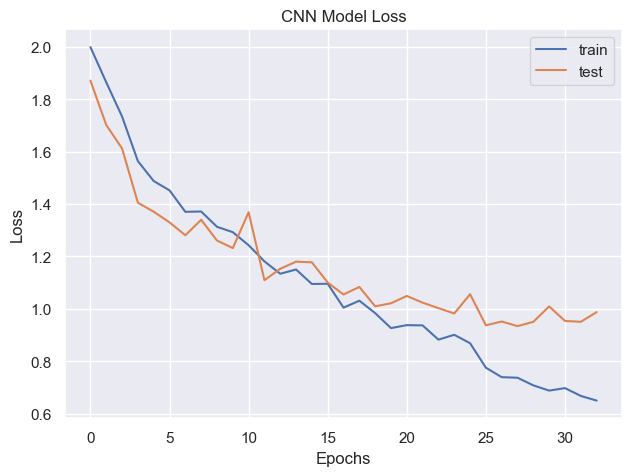

In [11]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Accuracy

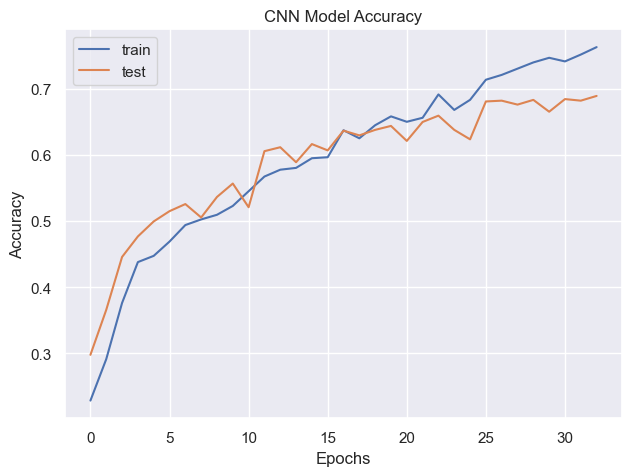

In [12]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Metrics

In [13]:
y_pred_CNN = cnn_model.predict(x_test)
y_pred_classes_CNN = np.argmax(y_pred_CNN, axis=1)
y_true_classes_CNN = np.argmax(y_test, axis=1)

accuracy_CNN = accuracy_score(y_true_classes_CNN, y_pred_classes_CNN)
precision_CNN  = precision_score(y_true_classes_CNN, y_pred_classes_CNN, average='weighted')
recall_CNN = recall_score(y_true_classes_CNN, y_pred_classes_CNN, average='weighted')
f1_CNN = f1_score(y_true_classes_CNN, y_pred_classes_CNN, average='weighted')

confusion_mat_CNN = confusion_matrix(y_true_classes_CNN, y_pred_classes_CNN)

print("Accuracy:", accuracy_CNN)
print("Precision:", precision_CNN)
print("Recall:", recall_CNN)
print("F1-Score:", f1_CNN)
print("Confusion Matrix:")
print(confusion_mat_CNN)

27/27 [==============================] - 7s 260ms/step
Accuracy: 0.6758045292014303
Precision: 0.6791669050189082
Recall: 0.6758045292014303
F1-Score: 0.6769136327634114
Confusion Matrix:
[[170   7   9  12   4   3   0   1]
 [  6  25   1   5  13   5   3   2]
 [  6   3 101   3   3   0   1  17]
 [  9  12   4  58   8   9   1   0]
 [  4  13   3  11 112  15   1   0]
 [  5   2   1   8  18  26   1   1]
 [  1   4   2   0   1   4  10   0]
 [  6   2  17   3   0   2   0  65]]


#### Evaluation

- `Accuracy`:The accuracy score denotes that the model accurately predicts the flower category with an approximate rate of 67.58%.

- `Precision`: The precision score of 0.6792 indicates that the model's accuracy in predicting a particular flower category is approximately 67.92%.

- `Recall`: The recall score, which is also referred to as sensitivity or true positive rate, denotes the capacity of the model to accurately recognize occurrences of a particular flower category. The recall score of 0.6758 suggests that the model is able to capture around 67.58% of the true occurrences of each flower category.

- `F1`: The F1-score is a statistical measure that represents the harmonic mean of precision and recall. It is commonly used to evaluate the performance of a model, providing a balanced assessment of its effectiveness. The F1-score value of 0.6769 suggests a consistent level of performance with regards to precision and recall.

- `Confusion Matrix`: The confusion matrix  is evident that the model exhibits varying levels of performance across different flower categories. Categories 1(Babi), 3(Chrysanthemum), and 5 (Lisianthus) exhibit a greater number of accurate predictions, as evidenced by elevated values along the diagonal. Nonetheless, misclassifications are evident in the off-diagonal elements.

In general, the model exhibits moderate performance in classifying the categories of flowers. The metrics of accuracy, precision, recall, and F1-score demonstrate a consistent level of performance. However, upon examining the confusion matrix, it is evident that certain categories are predicted with greater accuracy than others and the misclassifications of the model is quite high.

### ResNet50V2 Model


ResNet50v2 is a variation of the Residual Neural Network (ResNet) architecture that has made notable progress in the field of deep learning. ResNet50v2 is a specialized model that has been developed specifically for image recognition tasks. It has gained significant recognition in the field due to its exceptional performance. The network comprises 50 layers and integrates enhanced architectural and training methodologies. A notable attribute of this system is its utilization of residual connections, which effectively tackle the issue of vanishing gradients and facilitate the training of deep neural networks. ResNet50v2 employs residual blocks to capture intricate details and acquire hierarchical features, which facilitate the extraction of intricate representations. The model additionally derives advantages from batch normalization, a technique that enhances the stability of the learning process. The ResNet50v2 model has demonstrated exceptional performance in image recognition tasks and remains a popular choice for computer vision applications, including but not limited to image classification and object detection. The progress made in this field has facilitated the development of more sophisticated and precise neural networks.

**ResNet50V2: Advantages and Disadvantages**

> **Advantages**
1. `Improved Performance`: In image recognition benchmarks and contests, ResNet50v2 outperforms earlier models in accuracy.

2. `Deep Network Training`: ResNet50v2's residual connections allow deep network training without gradients. The model can capture more complicated patterns and achieve better accuracy.

3. `Hierarchical Feature Learning`: ResNet50v2's residual blocks let the network extract more complicated representations as input moves between layers. This improves data understanding and recognition.

4. `Generalization Capability`: ResNet50v2's batch normalization stabilizes learning, speeds convergence, and increases generalization. The model can handle unseen data and picture input fluctuations.

> **Disadvantages**
1. `Computational Complexity`: ResNet50v2, similar to CNN, is computationally costly to train and deploy, particularly with several layers. ResNet50v2 training may need GPUs.

2. `Large Model Size`: ResNet50v2's depth and intricacy make it difficult to install on devices with limited memory or bandwidth.

3. `Interpretability`: ResNet50v2's complex design makes understanding its inner workings difficult. Explaining why the model produced a forecast or which characteristics affected it may be tricky.

4. `Training Data Requirement`: Like other deep learning models, ResNet50v2 needs a lot of labeled training data to generalize and be accurate. In specialist fields, acquiring and compiling such datasets is time-consuming and expensive.

**ResNet50V2: Architecture**

![ResNet50V2 Architexture](https://www.researchgate.net/publication/359153551/figure/fig1/AS:1138765179428866@1648514184733/ResNet50v2-architecture.jpg "ResNet50V2 Architecture")

ResNet50v2 is composed of a total of 50 layers. The preponderance of these 50 layers are convolutional layers. ResNet50v2 is comprised of 49 convolutional layers, which play a vital role in extracting features from input data, and one fully connected layer.

ResNet50v2's initial layers are composed of convolutional layers that extract features. These layers perform a series of convolutional operations on the input image, capturing various visual patterns and characteristics. The convolutional layers are designed with a residual connection to enable the propagation of gradients and solve the problem of disappearing gradients.

After the convolutional layers, ResNet50v2 includes multiple residual blocks. Each residual block consists of numerous convolutional layers with shortcut connections. These shortcut connections enable the network to learn residual mappings, encoding the input image's fine-grained details and high-level characteristics. The residual blocks facilitate hierarchical feature learning, allowing the network to extract increasingly complex representations as data travels through the layers.

ResNet50v2 typically incorporates global average pooling after residual blocks, which reduces the spatial dimensions of the features to a fixed size. This operation pools the feature maps from multiple spatial locations, allowing the network to collect global data.

ResNet50v2 concludes with a layer that is entirely interconnected. This layer transfers the previous layers' output to the desired number of classes for classification tasks. This layer computes the ultimate probabilities or scores for each class identifier, enabling the network to make predictions.

ResNet50v2's use of skip connections, residual blocks, and deep layer structures facilitates the effective training of deep neural networks and the extraction of complex representations from input data, making it ideally suited for image recognition tasks.

- This model is built on top of the pre-trained ResNet50V2 model from Keras.
- We firstly freeze the weights of the first 170 layers of the pre-trained ResNet50V2 to simplify the model.
- Then, we create our model by adding more layers to the model: 
    + Reduce output spatial dimensions via a Global Average Pooling (GAP) layer.
    + The GAP layer's output is classified by a Dense layer with 512 neurons and a ReLU activation function.
    + A Dropout layer that randomly drops 40% of input units to the following layer to prevent overfitting.
    + To categorise, a dense layer with a softmax activation function.

In [14]:
ResNet50V2_base_model = ResNet50V2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False)

for layer in ResNet50V2_base_model.layers[:170]:
    layer.trainable = False

ResNet50V2_model = Sequential([
    ResNet50V2_base_model,
    GAP(),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.4),
    Dense(num_categories, activation='softmax')
])

- We set up the optimizer, loss function and evaluation metric before training the model.
- Then, we print a summary of the model architecture which includes the number of parameters in each layer and the output shape of each layer as well.

In [15]:
ResNet50V2_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy' , metrics = ['accuracy'])

ResNet50V2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,617,992
Trainable params: 8,932,872
Non-trainable params: 15,685,120
__________________________________

- Then, we fit the training data into the model.

In [16]:
ResNet50V2_history = ResNet50V2_model.fit(data_aug.flow(x_train,y_train, batch_size= batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, callbacks = callbacks)

Epoch 1/70
52/52 [==============================] - 196s 4s/step - loss: 1.2188 - accuracy: 0.5796 - val_loss: 4.1455 - val_accuracy: 0.5113 - lr: 0.0010
Epoch 2/70
52/52 [==============================] - 190s 4s/step - loss: 0.8264 - accuracy: 0.7283 - val_loss: 2.6670 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 3/70
52/52 [==============================] - 189s 4s/step - loss: 0.6813 - accuracy: 0.7687 - val_loss: 1.5640 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 4/70
52/52 [==============================] - 190s 4s/step - loss: 0.5738 - accuracy: 0.8058 - val_loss: 2.5119 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 5/70
52/52 [==============================] - 189s 4s/step - loss: 0.5410 - accuracy: 0.8225 - val_loss: 0.9597 - val_accuracy: 0.7330 - lr: 0.0010
Epoch 6/70
52/52 [==============================] - 189s 4s/step - loss: 0.4373 - accuracy: 0.8441 - val_loss: 1.8828 - val_accuracy: 0.6174 - lr: 0.0010
Epoch 7/70
52/52 [==============================] - 188s 4s/step - loss: 0.3

#### Loss Function

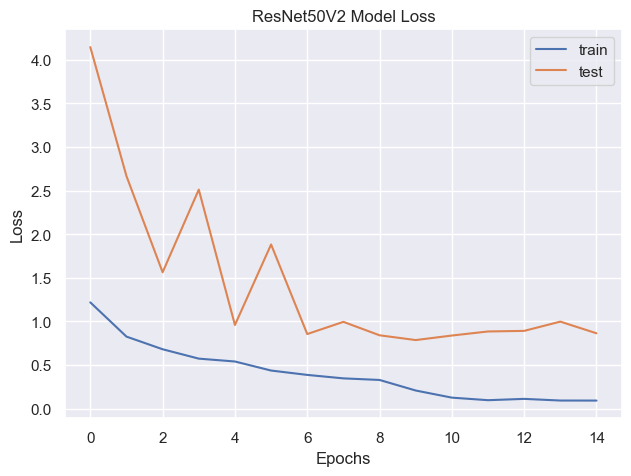

In [17]:
plt.plot(ResNet50V2_history.history['loss'])
plt.plot(ResNet50V2_history.history['val_loss'])
plt.title('ResNet50V2 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Accuracy

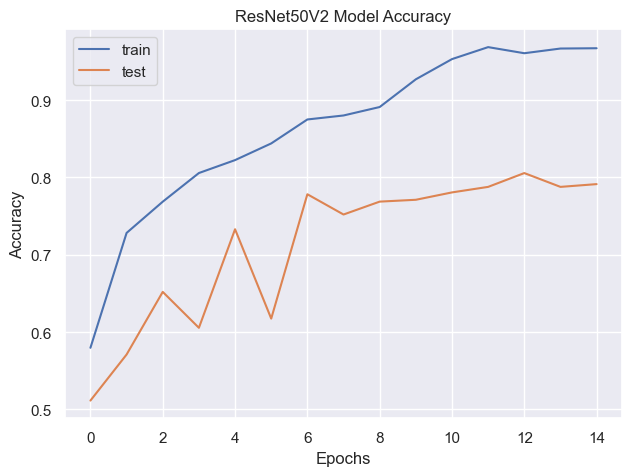

In [18]:
plt.plot(ResNet50V2_history.history['accuracy'])
plt.plot(ResNet50V2_history.history['val_accuracy'])
plt.title('ResNet50V2 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Metrics

In [27]:
y_pred_ResNet50V2 = ResNet50V2_model.predict(x_test)
y_pred_classes_ResNet50V2 = np.argmax(y_pred_ResNet50V2, axis=1)
y_true_classes_ResNet50V2 = np.argmax(y_test, axis=1)

accuracy_ResNet50V2 = accuracy_score(y_true_classes_ResNet50V2, y_pred_classes_ResNet50V2)
precision_ResNet50V2  = precision_score(y_true_classes_ResNet50V2, y_pred_classes_ResNet50V2, average='weighted')
recall_ResNet50V2 = recall_score(y_true_classes_ResNet50V2, y_pred_classes_ResNet50V2, average='weighted')
f1_ResNet50V2 = f1_score(y_true_classes_ResNet50V2, y_pred_classes_ResNet50V2, average='weighted')

confusion_mat_ResNet50V2 = confusion_matrix(y_true_classes_ResNet50V2, y_pred_classes_ResNet50V2)

print("Accuracy:", accuracy_ResNet50V2)
print("Precision:", precision_ResNet50V2)
print("Recall:", recall_ResNet50V2)
print("F1-Score:", f1_ResNet50V2)
print("Confusion Matrix:")
print(confusion_mat_ResNet50V2)

27/27 [==============================] - 41s 2s/step
Accuracy: 0.7711561382598331
Precision: 0.7794825137930841
Recall: 0.7711561382598331
F1-Score: 0.7712525247197796
Confusion Matrix:
[[174   2  13   5   3   2   0   7]
 [  0  43   1   4   4   4   4   0]
 [  2   0 107   1   2   1   4  17]
 [  0   4   2  86   7   1   1   0]
 [  1   6   3  14 129   4   1   1]
 [  1   4   1   5  11  40   0   0]
 [  0   0   1   1   1   1  18   0]
 [  5   2  32   5   0   0   1  50]]


#### Evaluation

- `Accuracy`: The ResNet50v2 model has demonstrated an accuracy score of 0.7712, suggesting a superior level of precision in its predictions when compared to the CNN model.

- `Precision`: The precision score of 0.7795 suggests that the ResNet50v2 model has an accuracy of around 77.95% in predicting a specific flower category.

- `Recall`: Based on the recall score of 0.7712, it can be inferred that the ResNet50v2 model has the ability to accurately identify approximately 77.12% of the actual instances of each flower category.

- `F1`: The F1-score value of 0.7713 indicates a consistent level of performance in terms of precision and recall for the ResNet50v2 model.

- `Confusion Matrix`: The performance of the ResNet50v2 model, as indicated by its confusion matrix, exhibits enhancement in comparison to the CNN model. Categories 1 (Babi), 3 (Chrysanthemum), and 5 (Lisianthus) demonstrate a higher number of precise predictions, as evidenced by increased values on the diagonal. The ResNet50v2 model exhibits improved distribution of precise predictions among various flower categories.

The ResNet50v2 model demonstrates noteworthy enhancements in accuracy, precision, recall, and F1-score when compared to the CNN model. The ResNet50v2 model exhibits superior accuracy and precision scores, suggesting a more precise categorization of flower types. Furthermore, the ResNet50v2 model exhibits superior performance in accurately capturing the actual instances of each category, leading to an enhanced recall score. The findings are further supported by the confusion matrix, which indicates that the ResNet50v2 model demonstrates greater accuracy in predicting various flower categories.

In terms of classification performance, the ResNet50v2 model outperforms the CNN model, exhibiting superior accuracy and more favorable prediction outcomes.

### VGG19 Model

In the field of computer vision, VGG19 is one of the most prominent convolutional neural network architectures. VGG19, created by the Visual Geometry Group at Oxford University, is renowned for its simplicity and effectiveness. VGG19 has 19 layers, 16 of which are convolutional and 3 of which are fully linked, and it uses a sequential sequence of 3x3 filters repeated followed by max pooling for downsampling. With this setup, VGG19 can accurately capture complex visual cues, giving it a powerful tool for picture categorization. In the last stages of the architecture, the fully linked layers hone the retrieved characteristics and provide the final classification result. VGG19 has shown remarkable performance on many picture recognition benchmarks, demonstrating its capacity to learn and generalize complicated visual patterns despite its relatively high number of parameters. VGG19 has been extensively accepted for computer vision applications because to its simplicity and efficacy, which have pushed the limits of deep learning in visual perception.

**VGG19: Advantages and Disadvantages**

> **Advantages**
1. `Strong Performance`:VGG19 succeeds at picture categorization. On benchmark datasets, it captured nuanced visual elements with state-of-the-art precision.

2. `Simplicity and Uniformity`: VGG19's architecture consists of repeating blocks of convolutional layers and max pooling layers. It's simple, making it popular with academics and practitioners.

3. `Transfer Learning`: VGG19's pre-trained models on big datasets may be utilized for transfer learning. Fine-tuning the learnt features on particular tasks or datasets with limited training data improves performance and convergence.

> **Disadvantages**
1. `High Computational Requirements`: VGG19 contains many parameters because to its deep design with numerous layers. This makes training and inference computationally intensive. VGG19 training requires strong GPUs and patience.

2. `Memory Consumption`: VGG19's many parameters use memory, especially during training. In resource-constrained contexts, lower-end devices may not fit the model.

3. `Overfitting`: VGG19's deep architecture with many parameters might overfit, particularly with minimal training data. Dropout and weight decay are needed to fix this and increase generality.

4. `Lack of Localization Capability`: VGG19 cannot locate objects in images. High-level picture categorization is its main emphasis. In object identification and semantic segmentation, this may restrict object localisation.

5. `Design Complexity`: VGG19's simplicity may be a benefit and a drawback. Compared to residual networks, convolutional and pooling layer stacking creates a deeper and more parameter-heavy architecture.

**VGG19: Architecture**

![VGG19 Architexture](https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg "VGG19 Architecture")

VGG19 contains 19 layers, the majority of which are convolutional layers, and one completely connected layer for classification.

Initial VGG19 layers are devoted to feature extraction. These convolutional layers perform a series of convolutions on the input image, capturing a variety of visual patterns and traits. The use of tiny 3x3 filters throughout the network enables the extraction of more specific features.

Following the convolutional layers, VGG19 consists of multiple convolutional layer-containing segments. These blocks contribute to the hierarchical learning of features, allowing the network to extract increasingly sophisticated representations as the data travels through the layers.

After the convolutional blocks, VGG19 incorporates pooling of global averages. This operation effectively combines information from multiple spatial locations by reducing the spatial dimensions of the feature maps to a fixed size. This operation facilitates the collection of global information about the features.

Finally, VGG19 concludes with a stratum that is completely interconnected. This layer transfers the output of the previous layers to the number of classes desired for classification tasks. It computes probabilities or scores for each class label, thereby enabling the network to make predictions.

With its emphasis on stacked convolutional layers and smaller filters, VGG19's deep architecture enables it to learn complex visual features and accomplish high accuracy in image recognition tasks.

#### Build and Train Model

- This model is built on top of the pre-trained VGG19 model from Keras.
- We firstly freeze the weights of the first 19 layers of the pre-trained VGG19 to simplify the model.
- Then, we create our model by adding more layers to the model: 
    + A MaxPool2D layer to downsample the feature maps.
    + A Flatten layer to convert output into a 1D array.
    + A Dense layer with a softmax activation function to classify the images into one of the eight categories. 

In [20]:
VGG19_based_model = VGG19(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False)

for layer in VGG19_based_model.layers[:19]:
    layer.trainable = False

VGG19_model = Sequential([
    VGG19_based_model,
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(num_categories , activation='softmax')
])

- We set up the optimizer, loss function and evaluation metric before training the model.
- Then, we print a summary of the model architecture which includes the number of parameters in each layer and the output shape of each layer as well.


In [21]:
VGG19_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy' , metrics = ['accuracy'])

VGG19_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 512)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 22,123,848
Trainable params: 6,819,080
Non-trainable params: 15,304,768
__________________________________

- Then, we fit the training data into the model.

In [22]:
VGG19_history = VGG19_model.fit(data_aug.flow(x_train,y_train, batch_size= batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, callbacks = callbacks)

Epoch 1/70
52/52 [==============================] - 623s 12s/step - loss: 1.8345 - accuracy: 0.3271 - val_loss: 1.3793 - val_accuracy: 0.4946 - lr: 0.0010
Epoch 2/70
52/52 [==============================] - 612s 12s/step - loss: 1.3587 - accuracy: 0.5018 - val_loss: 1.2102 - val_accuracy: 0.5495 - lr: 0.0010
Epoch 3/70
52/52 [==============================] - 612s 12s/step - loss: 1.1819 - accuracy: 0.5720 - val_loss: 1.0632 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 4/70
52/52 [==============================] - 611s 12s/step - loss: 1.0645 - accuracy: 0.6207 - val_loss: 1.0788 - val_accuracy: 0.6138 - lr: 0.0010
Epoch 5/70
52/52 [==============================] - 610s 12s/step - loss: 1.0682 - accuracy: 0.6164 - val_loss: 0.9772 - val_accuracy: 0.6508 - lr: 0.0010
Epoch 6/70
52/52 [==============================] - 610s 12s/step - loss: 0.9656 - accuracy: 0.6492 - val_loss: 0.9165 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 7/70
52/52 [==============================] - 616s 12s/step - lo

#### Loss Function

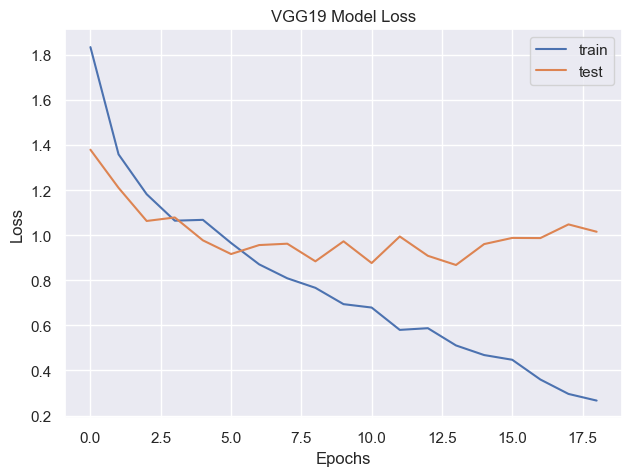

In [23]:
plt.plot(VGG19_history.history['loss'])
plt.plot(VGG19_history.history['val_loss'])
plt.title('VGG19 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Accuracy

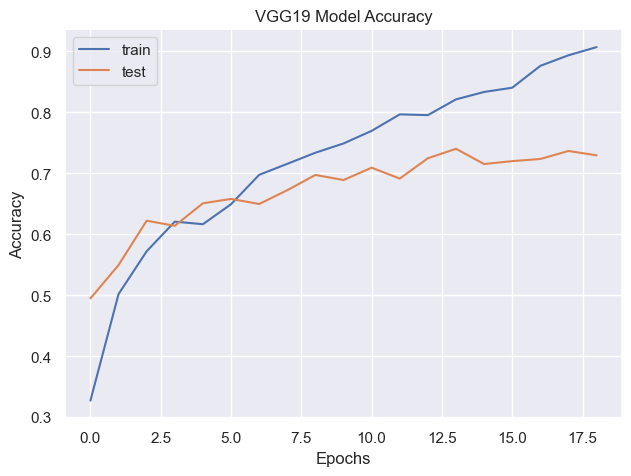

In [24]:
plt.plot(VGG19_history.history['accuracy'])
plt.plot(VGG19_history.history['val_accuracy'])
plt.title('VGG19 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Metrics

In [28]:
y_pred_VGG19 = VGG19_model.predict(x_test)
y_pred_classes_VGG19= np.argmax(y_pred_VGG19, axis=1)
y_true_classes_VGG19= np.argmax(y_test, axis=1)

accuracy_VGG19 = accuracy_score(y_true_classes_VGG19, y_pred_classes_VGG19)
precision_VGG19  = precision_score(y_true_classes_VGG19, y_pred_classes_VGG19, average='weighted')
recall_VGG19 = recall_score(y_true_classes_VGG19, y_pred_classes_VGG19, average='weighted')
f1_VGG19 = f1_score(y_true_classes_VGG19, y_pred_classes_VGG19, average='weighted')

confusion_mat_VGG19 = confusion_matrix(y_true_classes_VGG19, y_pred_classes_VGG19)

print("Accuracy:", accuracy_VGG19)
print("Precision:", precision_VGG19)
print("Recall:", recall_VGG19)
print("F1-Score:", f1_VGG19)
print("Confusion Matrix:")
print(confusion_mat_VGG19)

27/27 [==============================] - 156s 6s/step
Accuracy: 0.7401668653158522
Precision: 0.7459339934234794
Recall: 0.7401668653158522
F1-Score: 0.740860238334071
Confusion Matrix:
[[181   3   2  10   6   2   1   1]
 [  2  35   1   7  10   1   2   2]
 [  3   1  96   6   2   0   2  24]
 [  3   1   3  78  10   3   2   1]
 [  3  12   1  13 117  10   3   0]
 [  1   2   0  11  14  34   0   0]
 [  0   2   2   2   0   1  14   1]
 [  8   0  16   3   1   0   1  66]]


#### Evaluation

- `Accuracy`: The VGG190 model demonstrates an accuracy score of 0.7402, signifying a comparatively elevated level of accurate predictions in contrast to the CNN model, yet not as significant as ResNet50V2.

- `Precision`: The precision score of 0.7459 indicates that the VGG190 model's ability to predict a specific flower category is around 74.59% accurate.

- `Recall`: The recall score of 0.7402 suggests that the VGG190 model effectively captures approximately 74.02% of the actual instances of every flower category.

- `F1`:The F1-score of the VGG190 model is 0.7409, indicating a consistent level of performance in terms of precision and recall.

- `Confusion Matrix`: The VGG190 model exhibits enhancements in accuracy, precision, recall, and F1-score as compared to the CNN model. Despite the slightly lower accuracy and precision of the VGG190 model compared to the ResNet50v2 model, it exhibits reasonable performance. According to the recall score, the VGG190 model effectively captures a substantial portion of the actual instances of every flower category. The presented confusion matrix displays a reasonably equitable allocation of precise predictions among various flower categories, albeit certain categories demonstrate comparatively lower accuracy in contrast to others.

Overall, the VGG190 model exhibits favorable classification performance, characterized by high accuracy and reasonable precision and recall scores. Although the ResNet50v2 model exhibits superior performance in various metrics, the VGG190 model remains a dependable option for flower classification predictions.

### Plot chart to compare models

In [29]:
name = ['CNN','ResNet50V2','VGG19']
f1_score_arr = [f1_CNN,f1_ResNet50V2,f1_VGG19]
precision = [precision_CNN,precision_ResNet50V2,precision_VGG19]
accuracy = [accuracy_CNN,accuracy_ResNet50V2,accuracy_VGG19]

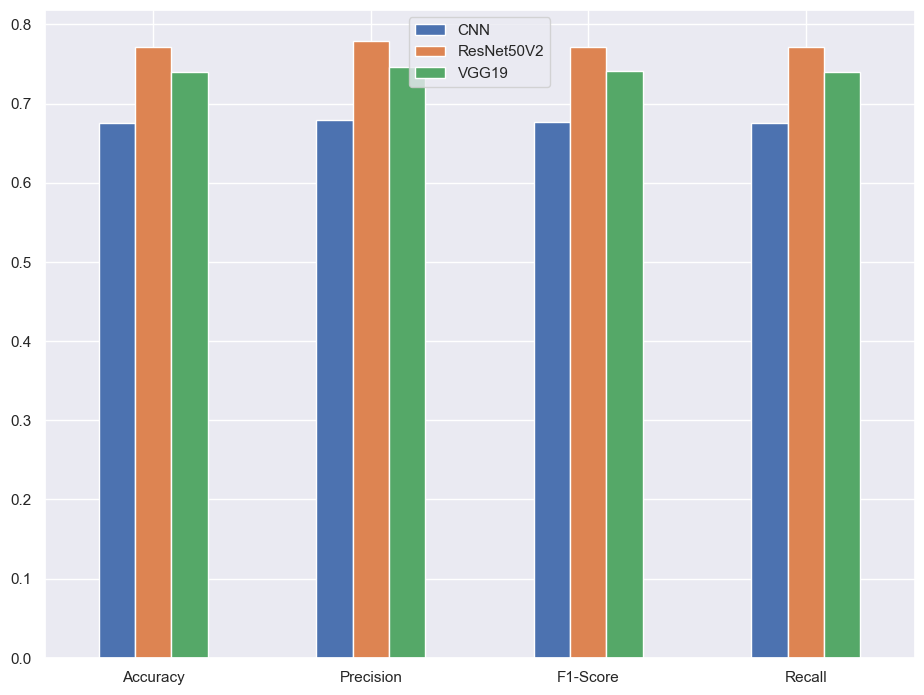

In [36]:
metrics     = ['Accuracy', 'Precision', 'F1-Score', 'Recall']
VGG19       =  [accuracy_VGG19,precision_VGG19,f1_VGG19,recall_VGG19]
ResNet50V2  = [accuracy_ResNet50V2,precision_ResNet50V2,f1_ResNet50V2,recall_ResNet50V2]
CNN         = [accuracy_CNN,precision_CNN,f1_CNN,recall_CNN]

# create the dataframe
chart_df = pd.DataFrame({'CNN': CNN, 'ResNet50V2': ResNet50V2, 'VGG19': VGG19}, index=metrics)

# Set the labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Metrics Bar Chart')

# Set the x-axis tick labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories)

# Add a legend
ax.legend()

# Show the chart
ax = chart_df.plot(kind='bar', figsize=(10, 8), rot=0)
plt.show()

### Save Best Model

In [26]:
import joblib
ResNet50V2_model.save('ResNet50V2_model.h5')